## imports

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

## Parameters

In [2]:
# Instantiate the model
input_size = 400  # Example input size
hidden_size = 64  # Example hidden size
num_layers = 2    # Example number of layers
num_features = 2  # Number of features in each twin

## Twin Rnn Model

In [3]:
class TwinRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_features):
        super(TwinRNN, self).__init__()
        
        # Define LSTM layers for twin 1 and twin 2
        self.lstmTwin1 = nn.LSTM(num_features, hidden_size, num_layers, batch_first=True)
        self.lstmTwin2 = nn.LSTM(num_features, hidden_size, num_layers, batch_first=True)
        
        # Initialize hidden states and cell states
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Initialize the hidden state with the correct shape
        self.hidden1 = (torch.zeros(num_layers, 1, hidden_size),  # Hidden state
                        torch.zeros(num_layers, 1, hidden_size))  # Cell state

        self.hidden2 = self.init_hidden()
        
    def init_hidden(self):
        # Initialize hidden state and cell state
        return (torch.zeros(self.num_layers, 1, self.hidden_size),
                torch.zeros(self.num_layers, 1, self.hidden_size))
        
    def forward(self, x):
        # Twin 1
        xTwin1 = x[:, :, :2]
        features1 = xTwin1[:, :, 0].unsqueeze(-1)  # Selecting the first feature column
        inputsTwin1 = features1.float()
        inputsTwin1 = inputsTwin1.permute(1, 0, 2)  # Transposing dimensions for LSTM input
        lstm_out1, (h_n1, c_n1) = self.lstmTwin1(inputsTwin1, self.hidden1)
        featMapTwin1 = torch.cat([h_n1[i, :, :] for i in range(h_n1.shape[0])], dim=1)
        
        # Twin 2
        xTwin2 = x[:, :, 2:4]
        features2 = xTwin2
        features2 = xTwin2[:, :, 0].unsqueeze(-1)  # Selecting the first feature column
        inputsTwin2 = inputsTwin2.permute(1, 0, 2)
        lstm_out2, (h_n2, c_n2) = self.lstmTwin2(inputsTwin2, self.hidden2)
        featMapTwin2 = torch.cat([h_n2[i, :, :] for i in range(h_n2.shape[0])], dim=1)
        
        # Combine twins
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        
        return featMap



        


## Data

In [4]:
# Load the CSV file
data = pd.read_csv('./data.csv')

data.head()

,num1,num2,label
0,81,67,0
1,67,25,1
2,93,78,0
3,58,54,0
4,23,83,1


## Train

In [5]:

# Convert the DataFrame to a PyTorch tensor
data_tensor = torch.tensor(data.values, dtype=torch.float32)


model = TwinRNN(input_size, hidden_size, num_layers, num_features)

# Perform inference
with torch.no_grad():
    output = model(data_tensor.unsqueeze(0))  # Add batch dimension
    print(output)

RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 1

## import

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


## Hyperparameters

In [33]:
input_size = 1
hidden_size = 128
learning_rate = 0.001
num_epochs = 30
batch_size = 1

## Data

In [28]:

class CustomDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = torch.tensor(X1, dtype=torch.float32)
        self.X2 = torch.tensor(X2, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]





In [29]:
data = pd.read_csv("./data.csv")

X1 = data['num1'].values.reshape(-1, 1)
X2 = data['num2'].values.reshape(-1, 1)
y = data['label'].values

# Normalize data
X1 = (X1 - np.mean(X1)) / np.std(X1)
X2 = (X2 - np.mean(X2)) / np.std(X2)


## Model

In [31]:
import torch
import torch.nn as nn

class TwinRRN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TwinRRN, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        _, (hidden1, _) = self.lstm1(x1)
        _, (hidden2, _) = self.lstm2(x2)
        combined_hidden = torch.cat((hidden1[-1], hidden2[-1]), dim=1)
        output = self.fc(combined_hidden)
        output = self.sigmoid(output)
        return output, (hidden1, hidden2)



## Train

In [34]:

# Create dataset and dataloader
dataset = CustomDataset(X1, X2, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = TwinRRN(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for x1, x2, labels in dataloader:
        optimizer.zero_grad()
        outputs, (hidden1, hidden2) = model(x1, x2)
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")



IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

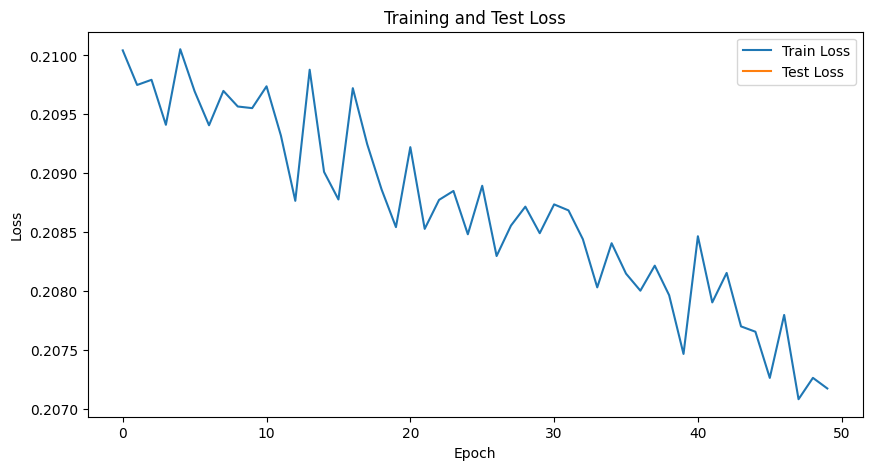

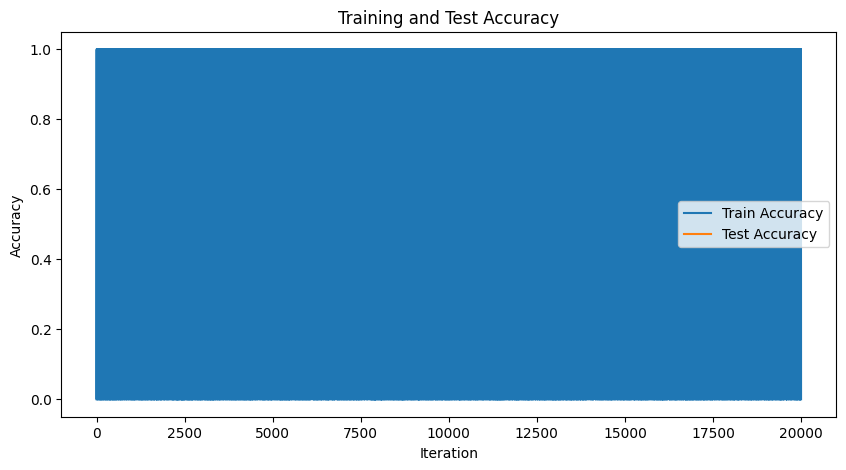

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a function to calculate accuracy
def calculate_accuracy(outputs, labels):
    # Perform necessary computations to calculate accuracy
    # This can depend on your task, for example for classification, you might use argmax
    # For regression, you might use a threshold or some other metric
    # Here's a simple example for binary classification assuming sigmoid activation
    predictions = (outputs > 0.5).float()
    correct = (predictions == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy.item()

# Assuming you have defined num_epochs, dataloader, model, optimizer, criterion
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()
    for x1, x2, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(x1, x2)
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Calculate training accuracy
        train_accuracy = calculate_accuracy(outputs.squeeze(1), labels)
        train_accuracies.append(train_accuracy)
        
    train_loss /= len(dataloader)
    train_losses.append(train_loss)
    



# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Evaluate

In [ ]:
with torch.no_grad():
    outputs = model(torch.tensor(X1, dtype=torch.float32), torch.tensor(X2, dtype=torch.float32))
    predictions = (outputs.numpy() > 0.5).astype(int)
    accuracy = np.mean(predictions.squeeze() == y)
    print(f"Accuracy: {accuracy}")


Accuracy: 0.325


In [ ]:
# Split data into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create a single data loader for the entire dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    correct_train = 0
    total_train = 0
    train_loss = 0.0
    for x1, x2, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(x1, x2)
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
        train_loss += loss.item()
    
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss / len(dataloader))
    
    # Testing
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for x1, x2, labels in dataloader:
            outputs = model(x1, x2)
            loss = criterion(outputs.squeeze(1), labels)
            
            # Calculate testing accuracy
            predicted = (outputs > 0.5).float()
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            
            test_loss += loss.item()
    
    test_accuracy = correct_test / total_test
    test_losses.append(test_loss / len(dataloader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracy}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracy}")


Epoch [1/50], Train Loss: 0.6183091121166945, Train Accuracy: 0.675, Test Loss: 0.6148315142467617, Test Accuracy: 0.675
Epoch [2/50], Train Loss: 0.6199103355780244, Train Accuracy: 0.675, Test Loss: 0.6155931507050991, Test Accuracy: 0.675
Epoch [3/50], Train Loss: 0.6192413777858019, Train Accuracy: 0.675, Test Loss: 0.6152693456783891, Test Accuracy: 0.675
Epoch [4/50], Train Loss: 0.6184597848728299, Train Accuracy: 0.675, Test Loss: 0.6146735177561641, Test Accuracy: 0.675
Epoch [5/50], Train Loss: 0.6181389037519693, Train Accuracy: 0.675, Test Loss: 0.6147029876708985, Test Accuracy: 0.675
Epoch [6/50], Train Loss: 0.618196677416563, Train Accuracy: 0.675, Test Loss: 0.6144632480666041, Test Accuracy: 0.675
Epoch [7/50], Train Loss: 0.6187107322737575, Train Accuracy: 0.675, Test Loss: 0.6143910703063011, Test Accuracy: 0.675
Epoch [8/50], Train Loss: 0.618107333779335, Train Accuracy: 0.675, Test Loss: 0.6143811877071857, Test Accuracy: 0.675
Epoch [9/50], Train Loss: 0.618020